In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
inp = torch.rand(10,1,160,160,36)

In [7]:
num_classes = 5

class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        
        self.conv1 = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(7, 7, 7), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        self.conv2 = nn.Sequential(
                nn.Conv3d(16, 4, kernel_size=(5, 5, 5), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        
        self.fc1 = nn.Linear(324, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
    

    def forward(self, x):
        # Set 1
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [8]:
model = CNN_Classifier()
out = model(inp)
print(out.shape)

torch.Size([10, 5])


In [10]:
import os
import nibabel as nib
import pandas as pd

dirname = 'ds000113b_R2.0.1/'
brain_volumes = []
class_labels = []
classes = ['ambient', 'symphonic', 'country', 'rocknroll','metal' ]
for subj in os.listdir(dirname):
    for run in range(1,3):
        path = dirname+"/"+subj+"/func" + "/" + subj + '_task-auditoryperception_run-0'+ str(run)                     
        img = nib.load(path + '_bold.nii.gz')
        data = img.get_fdata()

        df = pd.read_csv(path + '_events.tsv', sep='\t')
        genres = df['genre'].values
        run_volumes = df['run_volume'].values
        for i in range(len(genres)):
            start = run_volumes[i]
            if i < len(genres)-1:
                end = run_volumes[i+1]
            else:
                end = start + 6
            genre = genres[i]
            volume = data[:,:,:,start+1:end-1].mean(axis=-1)
            brain_volumes.append(volume)
            class_labels.append(classes.index(genre))
    break

In [11]:
len(brain_volumes), len(class_labels)

(50, 50)

In [12]:
brain_volumes[0].shape

(160, 160, 36)

(160, 160, 36, 153)


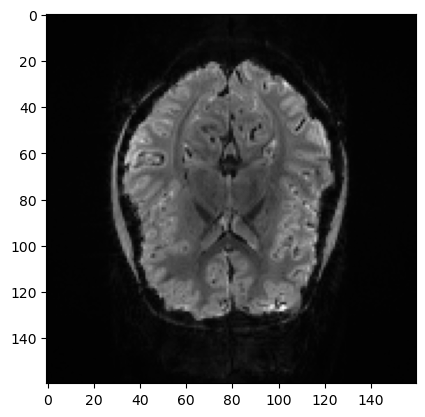

In [13]:
import matplotlib.pyplot as plt
a = brain_volumes[0]
plt.imshow(a[:,:,18].T, cmap='Greys_r')
print(data.shape)

In [14]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np

class BrainDataset(Dataset):
    def __init__(self, brain_volumes, class_labels):
        self.brain_volumes = brain_volumes
        self.class_labels = class_labels

    def __len__(self):
        return len(self.class_labels)

    def __getitem__(self, idx):
        temp_img = brain_volumes[idx]
        ind = np.where(brain_volumes[idx] < 200)
        temp_img[ind] = 0
        temp_img = temp_img / 200
        return temp_img, self.class_labels[idx]


In [15]:
# train_len = int(0.8 * len(brain_volumes))
# train_dataset = BrainDataset(brain_volumes[:train_len], class_labels[:train_len])
# val_dataset = BrainDataset(brain_volumes[train_len:], class_labels[train_len:])

dataset = BrainDataset(brain_volumes, class_labels)

In [16]:
train_dataset , val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [17]:
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24,shuffle=True)

In [18]:
for i, data in enumerate(train_loader):
    print(data[0].shape)
    print(data[1].shape)
    break

torch.Size([24, 160, 160, 36])
torch.Size([24])


tensor(2)


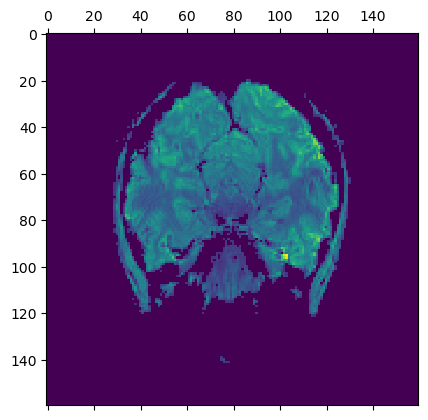

In [19]:
plt.matshow(data[0][0][:,:,6].T)
print(data[1][0])

In [20]:
def train_one_epoch(model, optimizer, dataloader,epoch):
    model.train()
    losses = []
    accs = []
    binaccs = []
    
    for i, (brain_volume, label) in enumerate(dataloader):
        optimizer.zero_grad()
        brain_volume = brain_volume.unsqueeze(1)
        
        brain_volume = brain_volume.to(device)
        label = label.to(device)
        
        
        pred = model(brain_volume)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        pred_labels = torch.argmax(pred, axis=1)
        
        acc = (pred_labels == label).sum() / len(label)
        accs.append(acc.item())
        
        pred_labels[pred_labels <=1] = 0
        pred_labels[pred_labels > 1] = 1
        label[label <=1 ]= 0 
        label[label > 1] = 1
        
        binacc = (pred_labels == label).sum() / len(label)
        binaccs.append( binacc.item() )
        
        print("Epoch ", epoch,": ", i, "/", len(dataloader), "loss :", loss.item(), "Acc :",acc , end='\r')
    print("train acc", np.mean(accs))
    print("train binary acc", np.mean(binaccs))
    return np.mean(losses), np.mean(accs)

def validate(model, optimizer, dataloader,epoch):
    model.eval()
    losses = []
    accs = []
    binaccs = []
    for i, (brain_volume, label) in enumerate(dataloader):
        brain_volume = brain_volume.unsqueeze(1)
        
        brain_volume = brain_volume.to(device)
        label = label.to(device)
         
        pred = model(brain_volume)
        loss = loss_fn(pred, label)

        pred_labels = torch.argmax(pred, axis=1)
        
        acc = (pred_labels == label).sum() / len(label)
        accs.append(acc.item())
        
        losses.append(loss.item())
        
        pred_labels[pred_labels <=1] = 0
        pred_labels[pred_labels > 1] = 1
        label[label <=1 ]= 0 
        label[label > 1] = 1
        binacc = (pred_labels == label).sum() / len(label)
        binaccs.append( binacc.item() )
        
    print("val acc", np.mean(accs))
    print("val binary acc", np.mean(binaccs))
    
    return np.mean(losses), np.mean(accs)

In [22]:
model = CNN_Classifier()
device = torch.device('cuda')
model.to(device)
model.double()

loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
num_epochs = 30
train_losses = []
val_losses = []
val_accs = []
train_accs = []
for epoch in range(num_epochs):
    loss, acc = train_one_epoch(model, optimizer, train_loader, epoch)
    val_loss, val_acc = validate(model, optimizer, val_loader, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc )
    print("---------------")

train acc 0.2604166679084301785255507670908 Acc : tensor(0.4375, device='cuda:0')
train binary acc 0.65625
val acc 0.20000000298023224
val binary acc 0.699999988079071
---------------
train acc 0.2395833358168602685772128663876 Acc : tensor(0.3125, device='cuda:0')
train binary acc 0.5208333432674408
val acc 0.20000000298023224
val binary acc 0.699999988079071
---------------
train acc 0.2604166716337204056369285059395 Acc : tensor(0.3125, device='cuda:0')
train binary acc 0.5833333432674408
val acc 0.20000000298023224
val binary acc 0.699999988079071
---------------
train acc 0.28125 loss : 1.4585843883151681 Acc : tensor(0.3125, device='cuda:0')
train binary acc 0.5208333432674408
val acc 0.20000000298023224
val binary acc 0.699999988079071
---------------
train acc 0.31252 loss : 1.5392451840269823 Acc : tensor(0.2500, device='cuda:0')
train binary acc 0.5833333432674408
val acc 0.20000000298023224
val binary acc 0.699999988079071
---------------
train acc 0.375 2 loss : 1.548221449

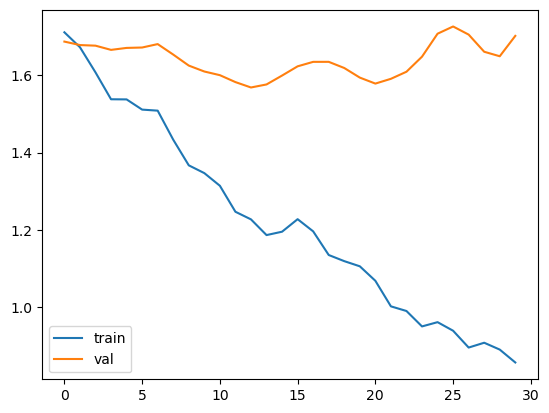

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()

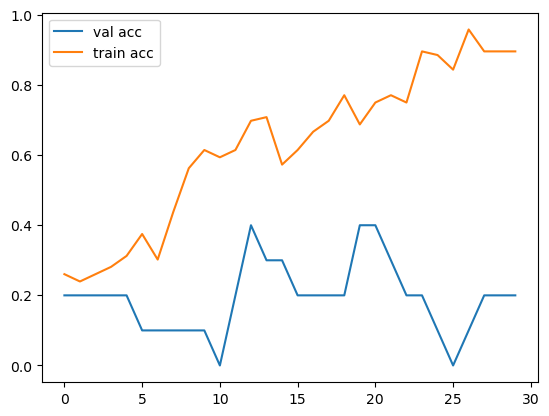

In [24]:
plt.plot(np.array(val_accs), label="val acc")
plt.plot(train_accs, label="train acc")
plt.legend()

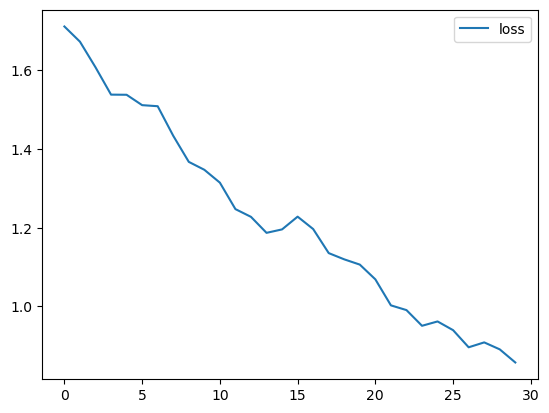

In [27]:

plt.plot(np.array(train_losses), label="loss")
plt.legend()